In [1]:
from glob import glob
from datetime import date
import ipywidgets as widgets

In [2]:
def filepath_info(filepath):
    *path, filename = filepath.rsplit('/')
    file_type, file_date, *rest = filename.split(',')
    file_date_day, file_date_month = file_date.split('.')
    return file_type, date(date.today().year, int(file_date_month), int(file_date_day))


def date_between(start, end, date):
    after_start = before_end = True
    if start:
        after_start = start <= date.replace(year=start.year)
    if end:
        before_end = end >= date.replace(year=end.year)
    return after_start and before_end


def check_type(selected_type, file_type):
    truth_table = {
        'oba': {'mikroblog', 'promoted'},
        'mikroblog': {'mikroblog'},
        'promowane': {'promoted'}
    }
    return file_type in truth_table[selected_type]


def sort_filenames(files):
    sorted_filenames = []
    for filename in files:
        split = [f.split('.') for f in filename.split(',')]
        sorted_filenames.append((split[1][1].zfill(2),
                                 split[1][0].zfill(2),
                                 split[0][0],
                                 split[2][0].zfill(2),
                                 split[2][1].zfill(2),
                                 filename))
    return [f[-1] for f in sorted(sorted_filenames)]


def filenames():
    files = []
    start_date, end_date = start_date_widget.value, end_date_widget.value
    posts_type = type_widget.value
    for filepath in glob('data/*'):
        file_type, file_date = filepath_info(filepath)
        if check_type(posts_type, file_type) and date_between(start_date, end_date, file_date):
            files.append(filepath)
    files = [f.split('/')[1][:-4] for f in files]
    return sort_filenames(files)

In [3]:
start_date_widget = widgets.DatePicker(
    description='Początek',
    disabled=False
)
end_date_widget = widgets.DatePicker(
    description='Koniec',
    disabled=False
)
date_widgets = widgets.HBox([start_date_widget, end_date_widget])
type_widget = widgets.RadioButtons(
    options=['mikroblog', 'promowane', 'oba'],
    description='Typy wpisów:',
    disabled=False
)
widgets.VBox([date_widgets, type_widget])

In [4]:
from wonted_dataset import WontedDataset, fetch_wykop_stats

In [5]:
def datasets():
    ds = WontedDataset()
    ds.load_data(filename='wonted_2.json')
    wykop = ds.get_val_dictionary()
    return {filename: {key.split('_')[1]: arr for key, arr in wykop.items() if filename in key} for filename in filenames()}

ds = datasets()

86it [00:00, 6199.69it/s]
9it [00:00, 3118.44it/s]
64it [00:00, 4254.80it/s]
99it [00:00, 5533.68it/s]
206it [00:00, 7193.81it/s]
99it [00:00, 6401.44it/s]
77it [00:00, 5998.43it/s]
358it [00:00, 6363.22it/s]
90it [00:00, 7822.60it/s]
73it [00:00, 6753.22it/s]
77it [00:00, 6751.43it/s]
33it [00:00, 6378.73it/s]
1110it [00:00, 8852.87it/s]


In [6]:
from joblib import load
from key_words import KeyWordsDetector

Using TensorFlow backend.


In [7]:
def predict_all(dataset, model, uid="RF"):
    kw=KeyWordsDetector(owndataset=False)
    keywordsdict={}
    tempdict={}
    for data in dataset.keys():
        for post in dataset[data].keys():
            tempdict[post]=kw.predict(dataset[data][post], model)
        keywordsdict[data]=tempdict
        tempdict={}
    return keywordsdict  

model = load('RF_wordnet2.joblib')
keywordsdict = predict_all(ds, model)

In [8]:
def wonted_data_per_file(filename, documents):
    ret = {}
    for doc, keywords in documents.items():
        source_file = f'{filename}_{doc}'
        likes = fetch_wykop_stats(source_file)
        for k in keywords:
            if k[0] in ret:
                ret[k[0]] += likes
            else:
                ret[k[0]] = likes
    return ret
      
    
def wonted_data_summed(keywords):
    return merge_dicts(*[wonted_data_per_file(filename, keywords[filename]) for filename in keywords.keys()])
    
    
def wonted_data_per_day(keywords):
    date_filenames = {}
    for filename in keywords:
        split = [f.split('.') for f in filename.split(',')]
        date = (split[1][1].zfill(2), split[1][0].zfill(2))
        if date in date_filenames:
            date_filenames[date].append(filename)
        else:
            date_filenames[date] = [filename]
    ret = {}
    for date, filenames in date_filenames.items():
        print(filenames)
        ret[date] = merge_dicts(*[wonted_data_per_file(filename, keywords[filename]) for filename in filenames])
    return ret

    
def merge_dicts(*dicts):
    ret = {}
    for d in dicts:
        for k, v in d.items():
            if k in ret:
                ret[k] += v
            else:
                ret[k] = v
    return ret

In [9]:
for filename, documents in keywordsdict.items():
    print(wonted_data_per_file(filename, documents))

{'cyfra': 929, 'xxd': 929, 'kuhwa': 348, 'dostaćbyć': 348, 'wpierdol': 348, 'jutro': 358, 'wstawić': 358, 'zbyt': 358, 'najebać': 358, 'kuchennerewolucje': 358, 'babcia': 1267, 'scrolluj': 1267, 'umarła': 1267, 'ʇoʞ': 199, 'pornopani': 149, 'wszystkoboners': 149, 'życie': 450, 'pokazmorde': 547, 'historyczny': 450, 'dzien': 432, 'cuuud': 432, 'boldupy': 155, 'potrzebować': 155, 'leczenie': 155, 'zbiórka': 155, 'kurwa': 155, 'heheszki': 373, 'juz': 97, 'wiec': 97, 'moge': 97, 'legitnie': 97, 'tak': 218, 'mecz': 272, 'bezbek': 387, 'niesamowity': 502, 'mame': 380, 'tan': 757, 'żarcie': 757, 'porcja': 757, 'piąteczek': 329, 'oddanie': 329, 'rzep': 254, 'nożownik': 254, 'tarnowo': 254}
{'policja': 555, 'bagieta': 555, 'logikarozowychpaskow': 1002, 'mirka': 781, 'tinder': 684, 'heheszki': 979, 'echo': 4970, 'taga': 621, 'jebłem': 621, 'gifnadzis': 453, 'gif': 453, 'porozumienie': 453, 'rap': 512, 'czarnuszyrap': 512, 'ważny': 921, 'firma': 921, 'zaraz': 921, 'prezes': 921, 'takaprawda': 916

{'ropczyce': 379, 'podkarpacie': 379, 'tamtejszy': 379, 'ośrodek': 709, 'zdrowie': 379, 'policjant': 463, 'toruński': 463, 'rozbójniczy': 463, 'mossadu': 523, 'belgia': 623, 'masowy': 665, 'przewóz': 665, 'trasa': 665, 'chiny': 665, 'zaginiona': 466, 'francuski': 1711, 'hiszpański': 1711, 'sieć': 276, 'handlowy': 276, 'karp': 276, 'komediowy': 280, 'allo': 560, 'obraz': 280, 'upadły': 280, 'madonna': 280, 'cyc': 280, 'bbc': 280, 'monitoring': 3108, 'sprawca': 3108, 'aventador': 3108, 'sekunda': 3108, 'hydrauliczny': 586, 'metal': 586, 'sexually': 464, 'anda': 464, 'cockpit': 464, 'krótki': 893, 'starcie': 245, 'hebron': 245, 'gorzowski': 223, 'jedynie': 703, 'oddział': 689, 'przedszkolny': 689, 'chłopiec': 689, 'tragedia': 689, 'tytuł': 754, 'żal': 856, 'interview': 251, 'nastolatek': 129, 'skalmierzyce': 129, 'wielkopolski': 129, 'warszawski': 245, 'restauracja': 245, 'linares': 496, 'nielegalny': 496, 'pakistan': 496, 'wycofywać': 365, 'marynarka': 365, 'biały': 1116, 'inspiracja': 3

In [14]:
dictionary = wonted_data_summed(keywordsdict)

In [11]:
def a(*args):
    print(args)

In [12]:
a(a for a in [1, 2, 3, 4])

(<generator object <genexpr> at 0x7ff8987c72b0>,)


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [22]:
import operator
sorted_x = sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)

In [23]:
print(sorted_x)

[('heheszki', 7436), ('polski', 5267), ('echo', 4970), ('państwo', 4799), ('salon', 4209), ('sprzedaż', 4209), ('komórkowy', 4209), ('mireczkow', 3993), ('gdańsk', 3993), ('polska', 3770), ('mirka', 3668), ('akcja', 3646), ('informacja', 3619), ('podrywajzwykopem', 3561), ('europa', 3530), ('interes', 3487), ('sekunda', 3417), ('hate', 3389), ('speech', 3389), ('kobieta', 3303), ('wykop', 3224), ('książka', 3185), ('monitoring', 3108), ('sprawca', 3108), ('aventador', 3108), ('proca', 3108), ('gotujzwykopem', 3027), ('jarmark', 2973), ('andrzej', 2920), ('tost', 2702), ('ściśle', 2675), ('strzec', 2675), ('mikołajkowy', 2608), ('potrójny', 2608), ('oszust', 2516), ('najbardziej', 2451), ('tvp', 2378), ('rozdajosteam', 2363), ('program', 2349), ('rolnikszukazony', 2304), ('rozdajo', 2186), ('antenty', 2060), ('przedsiębiorca', 2033), ('ręka', 2033), ('chiny', 2022), ('morawiecki', 2016), ('zesrales', 2016), ('rutyna', 1997), ('żyd', 1978), ('ojciec', 1936), ('francja', 1929), ('słaby', 

                word  likes
0           heheszki   7436
1             polski   5267
2               echo   4970
3            państwo   4799
4              salon   4209
5           sprzedaż   4209
6          komórkowy   4209
7          mireczkow   3993
8             gdańsk   3993
9             polska   3770
10             mirka   3668
11             akcja   3646
12        informacja   3619
13  podrywajzwykopem   3561
14            europa   3530
15           interes   3487
16           sekunda   3417
17              hate   3389
18            speech   3389
19           kobieta   3303


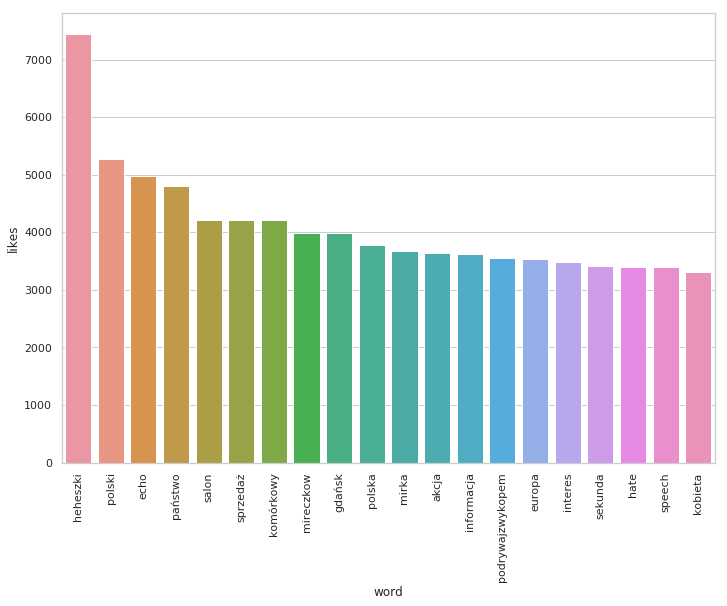

In [137]:
import pandas as pd
ax = []
ay = []
for i in range(0,20):
    ax.append(sorted_x[i][0])
    ay.append(sorted_x[i][1])
d = {'word': ax, 'likes': ay}
df = pd.DataFrame(data=d)
print(df)
sns.set(style="whitegrid", rc={'figure.figsize':(11.7,8.27)})
ax1 = sns.barplot(x='word', y='likes', data=df)
for item in ax1.get_xticklabels():
    item.set_rotation(90)

In [87]:
dailydictionary = wonted_data_per_day(keywordsdict)
dailydictionary.keys()
day=0
d = {'day': [], 'word': [], 'likes': []}
for key in dailydictionary.keys():
    dailydictionary[key] = sorted(dailydictionary[key].items(), key=operator.itemgetter(1), reverse=True)
    for i in range(0,40):
        d['day'].append(day)
        d['word'].append(dailydictionary[key][i][0])
        d['likes'].append(dailydictionary[key][i][1])
    day+=1
df = pd.DataFrame(data=d)
duplicated = df.duplicated(subset='word', keep=False)
for i in range(len(duplicated)):
    if duplicated[i]==True:
        print(df['day'][i], df['word'][i])


['mikroblog,30.11,9.00', 'mikroblog,30.11,21.00', 'promoted,30.11,9.00']
['mikroblog,1.12,9.00', 'mikroblog,1.12,21.00', 'promoted,1.12,9.00']
['mikroblog,2.12,9.00', 'mikroblog,2.12,21.00', 'promoted,2.12,9.00']
['mikroblog,3.12,9.00', 'mikroblog,3.12,21.00', 'promoted,3.12,9.00']
['mikroblog,4.12,9.00', 'mikroblog,4.12,21.00', 'promoted,4.12,9.00']
0 heheszki
1 heheszki
1 polski
1 mirka
1 państwo
1 europa
1 kobieta
1 rozdajo
1 podrywajzwykopem
1 żyd
2 polski
2 heheszki
2 kobieta
2 polska
2 żyd
2 europa
3 polska
3 rozdajo
4 państwo
4 podrywajzwykopem
4 mirka


['mikroblog,30.11,9.00', 'mikroblog,30.11,21.00', 'promoted,30.11,9.00']
['mikroblog,1.12,9.00', 'mikroblog,1.12,21.00', 'promoted,1.12,9.00']
['mikroblog,2.12,9.00', 'mikroblog,2.12,21.00', 'promoted,2.12,9.00']
['mikroblog,3.12,9.00', 'mikroblog,3.12,21.00', 'promoted,3.12,9.00']
['mikroblog,4.12,9.00', 'mikroblog,4.12,21.00', 'promoted,4.12,9.00']
     day  likes
0  01.12   1352
1  02.12   2924
2  03.12   2433
3  04.12    675
4  05.12    727


Text(0.5, 1.0, 'Słowo: heheszki w danym okresie czasu')

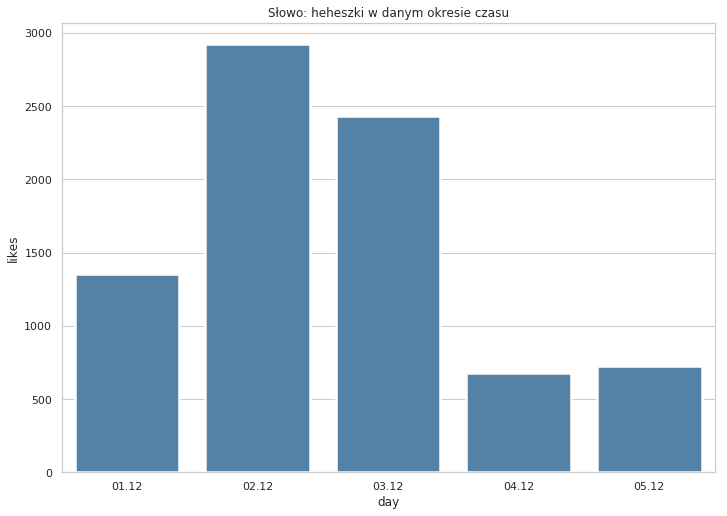

In [247]:
dailydictionary = wonted_data_per_day(keywordsdict)
dailydictionary.keys()
word='heheszki'
day=0
count=False
d = {'day': [], 'likes': []}
for key in dailydictionary.keys():
    dailydictionary[key] = sorted(dailydictionary[key].items(), key=operator.itemgetter(1), reverse=True)
    for i in range(len(dailydictionary[key])):
        if dailydictionary[key][i][0]==word:
            d['day'].append(day)
            d['likes'].append(dailydictionary[key][i][1])
            count=True
    if count==False:
        d['day'].append(day)
        d['likes'].append(675)
    count=False
    day+=1
d['day']=['01.12','02.12','03.12','04.12','05.12']
df = pd.DataFrame(data=d)
print(df)
title="Słowo: " + word + " w danym okresie czasu"
sns.set(style="whitegrid")
sns.barplot(x='day', y='likes', data=df,  linewidth=2.5, color='steelblue').set_title(title)


In [170]:
words=ax
temp=[]
count=False
data={}
for word in words:
    day=0
    dailydictionary = wonted_data_per_day(keywordsdict)
    for key in dailydictionary.keys():
        dailydictionary[key] = sorted(dailydictionary[key].items(), key=operator.itemgetter(1), reverse=True)
        for i in range(len(dailydictionary[key])):
            if dailydictionary[key][i][0]==word:
                temp.append(dailydictionary[key][i][1])
                count=True
        if count==False:
            temp.append(0)
        count=False
        day+=1
    data[word]=temp
    temp=[]
        

['mikroblog,30.11,9.00', 'mikroblog,30.11,21.00', 'promoted,30.11,9.00']
['mikroblog,1.12,9.00', 'mikroblog,1.12,21.00', 'promoted,1.12,9.00']
['mikroblog,2.12,9.00', 'mikroblog,2.12,21.00', 'promoted,2.12,9.00']
['mikroblog,3.12,9.00', 'mikroblog,3.12,21.00', 'promoted,3.12,9.00']
['mikroblog,4.12,9.00', 'mikroblog,4.12,21.00', 'promoted,4.12,9.00']
['mikroblog,30.11,9.00', 'mikroblog,30.11,21.00', 'promoted,30.11,9.00']
['mikroblog,1.12,9.00', 'mikroblog,1.12,21.00', 'promoted,1.12,9.00']
['mikroblog,2.12,9.00', 'mikroblog,2.12,21.00', 'promoted,2.12,9.00']
['mikroblog,3.12,9.00', 'mikroblog,3.12,21.00', 'promoted,3.12,9.00']
['mikroblog,4.12,9.00', 'mikroblog,4.12,21.00', 'promoted,4.12,9.00']
['mikroblog,30.11,9.00', 'mikroblog,30.11,21.00', 'promoted,30.11,9.00']
['mikroblog,1.12,9.00', 'mikroblog,1.12,21.00', 'promoted,1.12,9.00']
['mikroblog,2.12,9.00', 'mikroblog,2.12,21.00', 'promoted,2.12,9.00']
['mikroblog,3.12,9.00', 'mikroblog,3.12,21.00', 'promoted,3.12,9.00']
['mikroblog

   heheszki  polski  echo  państwo  salon  sprzedaż  komórkowy  mireczkow  \
0      1352       0  4970      289      0         0          0          0   
1      2924    1688     0     1544      0         0          0          0   
2      2433    2903     0        0      0         0          0          0   
3         0       0     0        0   4209      4209       4209       3993   
4       727     676     0     2966      0         0          0          0   

   gdańsk  polska  ...    akcja  informacja  podrywajzwykopem  europa  \
0       0     500  ...        0           0                 0     500   
1       0       0  ...        0           0               989    1521   
2       0    1068  ...        0         216                 0     828   
3    3993    2202  ...     3646        3224                 0     681   
4       0       0  ...        0         179              2572       0   

   interes  sekunda  hate  speech  kobieta    day  
0     3487        0     0       0      253  01

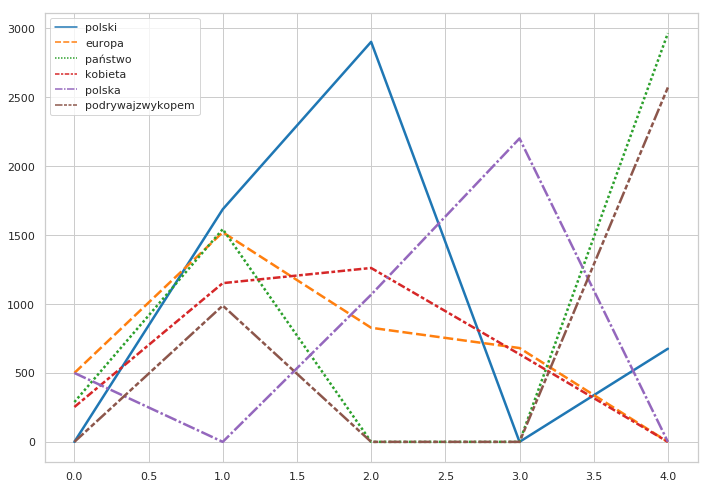

In [237]:
data['day']=['01.12','02.12','03.12','04.12','05.12']
data
df = pd.DataFrame(data=data)
print(df)
ax2 = sns.lineplot(data=[df['polski'], df['europa'], df['państwo'], df['kobieta'], df['polska'], df['podrywajzwykopem']], palette="tab10", linewidth=2.5)


[0    1352
1    2924
2    2433
3       0
4     727
Name: heheszki, dtype: int64, 0       0
1    1688
2    2903
3       0
4     676
Name: polski, dtype: int64, 0    4970
1       0
2       0
3       0
4       0
Name: echo, dtype: int64, 0     289
1    1544
2       0
3       0
4    2966
Name: państwo, dtype: int64, 0       0
1       0
2       0
3    4209
4       0
Name: salon, dtype: int64, 0       0
1       0
2       0
3    4209
4       0
Name: sprzedaż, dtype: int64, 0       0
1       0
2       0
3    4209
4       0
Name: komórkowy, dtype: int64, 0       0
1       0
2       0
3    3993
4       0
Name: mireczkow, dtype: int64, 0       0
1       0
2       0
3    3993
4       0
Name: gdańsk, dtype: int64, 0     500
1       0
2    1068
3    2202
4       0
Name: polska, dtype: int64, 0     781
1    1645
2       0
3       0
4    1242
Name: mirka, dtype: int64, 0       0
1       0
2       0
3    3646
4       0
Name: akcja, dtype: int64, 0       0
1       0
2     216
3    3224
4     179
Name: i

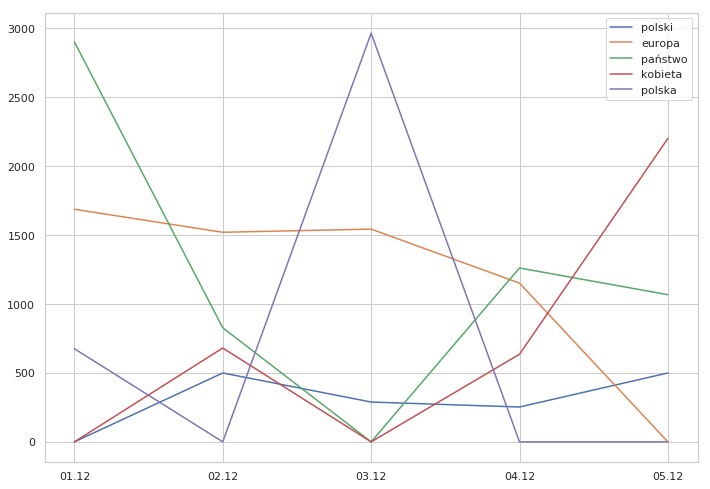

In [238]:
x=df['day']
y=[]
temp=[]
for columns in df:
    if columns!='day':
        y.append(df[columns])
print(y)
y=[df['polski'], df['europa'], df['państwo'], df['kobieta'], df['polska']]
plt.plot(x, y)
plt.legend(['polski', 'europa', 'państwo', 'kobieta', 'polska'])

In [239]:
fmri = sns.load_dataset("fmri")
print(fmri)

     subject  timepoint event    region    signal
0        s13         18  stim  parietal -0.017552
1         s5         14  stim  parietal -0.080883
2        s12         18  stim  parietal -0.081033
3        s11         18  stim  parietal -0.046134
4        s10         18  stim  parietal -0.037970
5         s9         18  stim  parietal -0.103513
6         s8         18  stim  parietal -0.064408
7         s7         18  stim  parietal -0.060526
8         s6         18  stim  parietal -0.007029
9         s5         18  stim  parietal -0.040557
10        s4         18  stim  parietal -0.048812
11        s3         18  stim  parietal -0.047148
12        s2         18  stim  parietal -0.086623
13        s1         18  stim  parietal -0.046659
14        s0         18  stim  parietal -0.075570
15       s13         17  stim  parietal -0.008265
16       s12         17  stim  parietal -0.088512
17        s7          9  stim  parietal  0.058897
18       s10         17  stim  parietal -0.016847
